# Generative Models with AE, VAE, and GANs
This notebook demonstrates the construction, training, and comparison of three generative models: Autoencoder (AE), Variational Autoencoder (VAE), and Generative Adversarial Network (GAN). We will use the Fashion-MNIST dataset.

## 1. Setup and Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

/Users/oussama/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Load and Preprocess Data (Fashion-MNIST)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
img_shape = x_train.shape[1:]
latent_dim = 64 # Latent dimension for AE and VAE
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Image shape: {img_shape}")

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Image shape: (28, 28, 1)


### Display some training images

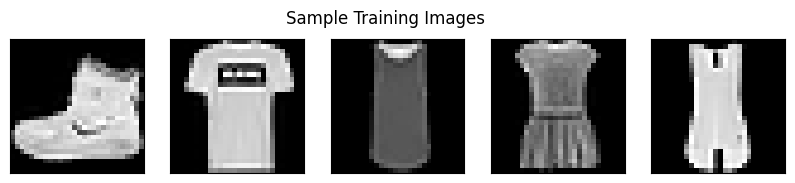

In [5]:
plt.figure(figsize=(10, 2))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Sample Training Images")
plt.show()

## 3. Autoencoder (AE)
An Autoencoder learns to compress data (encoding) and then reconstruct it (decoding).

### 3.1. AE Model Definition

#### Encoder

In [6]:
x_train = np.squeeze(x_train)
x_train = x_train.reshape(-1, 28, 28, 1)
input_img_ae = Input(shape=img_shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img_ae)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
encoded_ae = Flatten()(x) # Flatten before dense layer for latent space
encoded_ae = Dense(latent_dim, activation='relu')(encoded_ae)

encoder_ae = Model(input_img_ae, encoded_ae, name="encoder_ae")

#### Decoder

In [7]:
decoder_input_ae = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_input_ae)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
decoded_ae = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_ae = Model(decoder_input_ae, decoded_ae, name="decoder_ae")

#### Autoencoder Model


In [8]:
autoencoder_ae = Model(input_img_ae, decoder_ae(encoder_ae(input_img_ae)), name="autoencoder_ae")
autoencoder_ae.compile(optimizer='adam', loss='binary_crossentropy')

encoder_ae.summary()
decoder_ae.summary()
autoencoder_ae.summary()

Model: "encoder_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_ae (Functional)         │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_ae (Functional)         │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. AE Training


In [9]:
history_ae = autoencoder_ae.fit(x_train, x_train,
                                epochs=100, # Reduced for faster execution, ideally 50-100
                                batch_size=128,
                                shuffle=True,
                                validation_data=(x_test, x_test))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.4034 - val_loss: 0.2886
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.2833 - val_loss: 0.2785
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2753 - val_loss: 0.2739
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2711 - val_loss: 0.2708
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2681 - val_loss: 0.2691
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2669 - val_loss: 0.2681
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2649 - val_loss: 0.2665
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2642 - val_loss: 0.2657
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2637 - val_loss: 0.2654
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2634 - val_loss: 0.2665
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2621 - val_loss: 0.2644
Epoch 12/100
469/46

### 3.3. AE Results

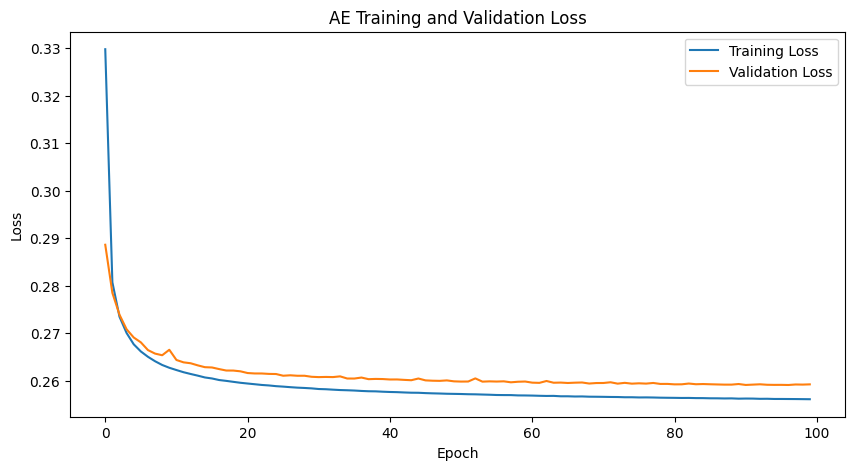

In [10]:
# Plot training loss

plt.figure(figsize=(10, 5))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('AE Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


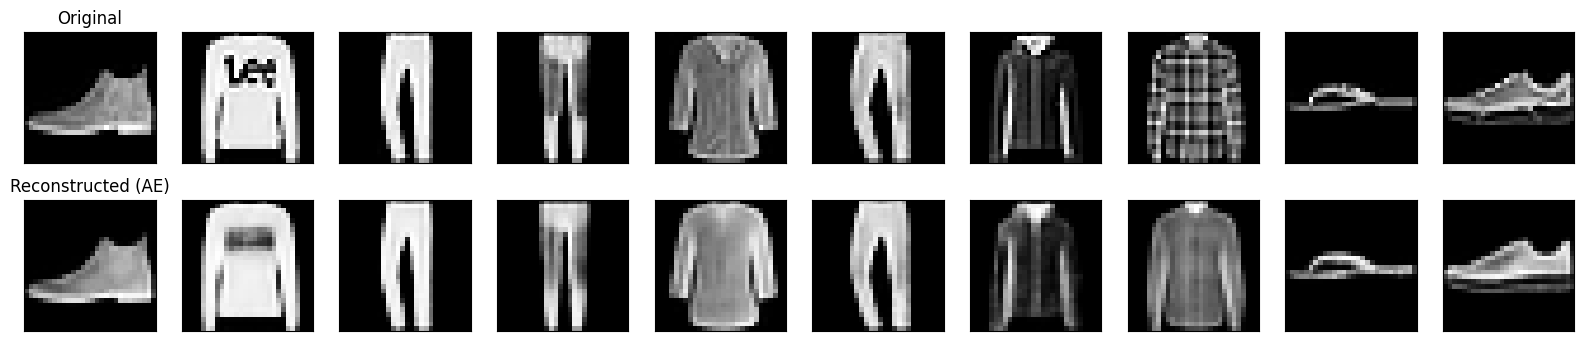

In [11]:
# Display original and reconstructed images
def display_ae_results(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed (AE)")
    plt.show()

reconstructed_imgs_ae = autoencoder_ae.predict(x_test)
display_ae_results(x_test, reconstructed_imgs_ae)

## 4. Variational Autoencoder (VAE)

A VAE learns a probabilistic mapping to a latent space, allowing for generation of new data.

### 4.1. VAE Model Definition

In [ ]:
# Sampling function (reparameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


#### Encoder

In [ ]:
# Encoder
input_img_vae = Input(shape=img_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img_vae)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder_vae = Model(input_img_vae, [z_mean, z_log_var, z], name="encoder_vae")


#### Decoder

In [ ]:
# Decoder (same architecture as AE's decoder for consistency)
decoder_input_vae = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_input_vae)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
decoded_vae_output = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_vae = Model(decoder_input_vae, decoded_vae_output, name="decoder_vae")


In [ ]:

outputs_vae = decoder_vae(encoder_vae(input_img_vae)[2])
vae = Model(input_img_vae, outputs_vae, name='vae')


### VAE Loss

In [ ]:

# Custom VAE class
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, reconstructed)
        ) * 28 * 28

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

encoder_vae.summary()
decoder_vae.summary()
vae = VAE(encoder_vae, decoder_vae)
vae.compile(optimizer='adam')


### 4.2. VAE Training

In [ ]:
history_vae = vae.fit(x_train, 
                      epochs=20, # Reduced for faster execution, ideally 50-100
                      batch_size=128,
                      validation_data=(x_test, None)) # No y_test needed as loss is internal


### 4.3. VAE Results

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['loss'], label='Training Loss')
plt.plot(history_vae.history['val_loss'], label='Validation Loss')
plt.title('VAE Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Display original and reconstructed images
def display_vae_reconstructed(original, vae_model, n=10):
    reconstructed = vae_model.predict(original[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed (VAE)")
    plt.show()

display_vae_reconstructed(x_test, vae)


In [ ]:
# Generate new images from latent space
def display_vae_generated(decoder, n=10):
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated_images = decoder.predict(random_latent_vectors)

    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Generated Images (VAE)")
    plt.show()

display_vae_generated(decoder_vae)


## 5. Generative Adversarial Network (GAN)
A GAN consists of a generator and a discriminator that compete against each other.

In [ ]:
gan_latent_dim = 100 # Latent dimension for GAN generator

### 5.1. GAN Model Definition (DCGAN-like architecture)

In [ ]:
# Generator
def build_generator():
    model = Sequential(name="generator")
    model.add(Dense(7 * 7 * 128, input_dim=gan_latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same')) # Output layer
    return model

generator_gan = build_generator()
generator_gan.summary()


In [ ]:
# Discriminator
def build_discriminator():
    model = Sequential(name="discriminator")
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator_gan = build_discriminator()
discriminator_gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator_gan.summary()


In [ ]:
# GAN (Combined Model)
discriminator_gan.trainable = False # Discriminator is not trained when training GAN

gan_input = Input(shape=(gan_latent_dim,))
img = generator_gan(gan_input)
gan_output = discriminator_gan(img)

gan = Model(gan_input, gan_output, name="gan")
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()


### 5.2. GAN Training

In [ ]:
epochs_gan = 10000 # Reduced for faster execution, ideally 10000+
_batch_size_gan = 64
save_interval = 50 # Interval to save generated images

# Rescale images to -1 to 1 for tanh activation if used, but sigmoid is fine with 0 to 1
# x_train_gan = (x_train.astype(np.float32) - 127.5) / 127.5
x_train_gan = x_train # Using 0-1 scaled images with sigmoid output

In [ ]:
# Ground truths
real = np.ones((_batch_size_gan, 1))
fake = np.zeros((_batch_size_gan, 1))

d_losses = []
g_losses = []

for epoch in range(epochs_gan):
    # --------------------- #
    #  Train Discriminator #
    # --------------------- #
    # Select a random batch of real images
    idx = np.random.randint(0, x_train_gan.shape[0], _batch_size_gan)
    real_imgs = x_train_gan[idx]

    # Generate a batch of new images
    noise = np.random.normal(0, 1, (_batch_size_gan, gan_latent_dim))
    gen_imgs = generator_gan.predict(noise)

    # Labels for real and fake images
    real = np.ones((_batch_size_gan, 1))  # Label for real images (1)
    fake = np.zeros((_batch_size_gan, 1))  # Label for fake images (0)

    # Train the discriminator
    d_loss_real = discriminator_gan.train_on_batch(real_imgs, real)
    d_loss_fake = discriminator_gan.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ----------------- #
    #  Train Generator  #
    # ----------------- #
    noise = np.random.normal(0, 1, (_batch_size_gan, gan_latent_dim))
    g_loss = gan.train_on_batch(noise, real)  # Train generator to fool discriminator

    # Save losses for monitoring
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    # Logging the losses
    print(f"Epoch {epoch+1}/{epochs_gan}")
    print(f"D loss: {d_loss[0]:.4f}, G loss: {g_loss:.4f}")

    # Check if losses are stuck or training is not progressing
    if epoch > 1 and abs(d_losses[-1] - d_losses[-2]) < 1e-5 and abs(g_losses[-1] - g_losses[-2]) < 1e-5:
        print("Training stuck, exiting early...")
        break

    # Save generated images at intervals
    if (epoch + 1) % save_interval == 0:
        r, c = 5, 5
        noise_display = np.random.normal(0, 1, (r * c, gan_latent_dim))
        gen_imgs_display = generator_gan.predict(noise_display)
        gen_imgs_display = 0.5 * gen_imgs_display + 0.5  # Rescale to 0-1 if necessary

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs_display[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.suptitle(f"Generated Images at Epoch {epoch+1}")
        plt.show()
        plt.close(fig)


### 5.3. GAN Results

In [ ]:
# Plot training losses
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display some final generated images

In [ ]:
def display_gan_generated(generator, n=10, latent_dim_val=gan_latent_dim):
    noise = np.random.normal(0, 1, (n, latent_dim_val))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Final Generated Images (GAN)")
    plt.show()

display_gan_generated(generator_gan)


## 6. Model Comparison and Conclusion

Briefly compare the outputs and characteristics of AE, VAE, and GAN.

- **Autoencoders (AE)** are good for dimensionality reduction and feature learning. Their reconstructions are typically faithful but not necessarily novel.
- **Variational Autoencoders (VAE)** can generate new, plausible samples by sampling from the learned latent space. The generated images are often blurrier than GANs but VAEs provide a smooth latent space.
- **Generative Adversarial Networks (GAN)** are known for producing sharp and realistic images. However, they can be harder to train (mode collapse, non-convergence).

This notebook provided a basic implementation of these three models. Further improvements can be made by using more complex architectures, more extensive training, and hyperparameter tuning.